In [1]:
!pip install xgboost
!pip install keras-tuner

In [3]:
#Import the required libraries

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
from scipy.stats import f_oneway
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import keras_tuner as kt
from keras.optimizers import Adam
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

In [3]:
#Load the dataset into a Pandas DataFrame

df = pd.read_csv('Dataset_Uber Traffic2.csv')

In [4]:
#Display the first few rows of the dataset

print(df.head())

        DateTime  Junction  Vehicles           ID
0  01/11/15 0:00         1        15  20151101001
1  01/11/15 1:00         1        13  20151101011
2  01/11/15 2:00         1        10  20151101021
3  01/11/15 3:00         1         7  20151101031
4  01/11/15 4:00         1         9  20151101041


In [5]:
#Summary statistics

print(df.describe())

           Junction      Vehicles            ID
count  48120.000000  48120.000000  4.812000e+04
mean       2.180549     22.791334  2.016330e+10
std        0.966955     20.750063  5.944854e+06
min        1.000000      1.000000  2.015110e+10
25%        1.000000      9.000000  2.016042e+10
50%        2.000000     15.000000  2.016093e+10
75%        3.000000     29.000000  2.017023e+10
max        4.000000    180.000000  2.017063e+10


In [6]:
#Information about the dataset

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB
None


In [7]:
#Handle missing values
#Check for missing values

print("\nMissing values before handling:")
print(df.isnull().sum())


Missing values before handling:
DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64


In [8]:
#Check for duplicate rows

duplicates = df.duplicated()

#Print the number of duplicate rows

print(f"Number of duplicate rows: {duplicates.sum()}")

Number of duplicate rows: 0


In [9]:
#Convert 'Junction' and 'ID' columns to categorical data types

df['Junction'] = df['Junction'].astype('category')
df['ID'] = df['ID'].astype('category')

#Display updated data types

print(df.dtypes)

DateTime      object
Junction    category
Vehicles       int64
ID          category
dtype: object


In [10]:
#Convert 'DateTime' column to datetime format

df['DateTime'] = pd.to_datetime(df['DateTime'], format='%d/%m/%y %H:%M')

#Display updated data types

print(df.dtypes)

DateTime    datetime64[ns]
Junction          category
Vehicles             int64
ID                category
dtype: object


In [11]:
#Group by Junction and hourly intervals, then aggregate vehicle counts

hourly_traffic = df.groupby(['Junction', df['DateTime'].dt.hour])['Vehicles'].sum().reset_index()

#Rename columns for clarity

hourly_traffic.columns = ['Junction', 'Hour', 'Total Vehicles']

#Display aggregated data

print(hourly_traffic.head())

  Junction  Hour  Total Vehicles
0        1     0           27809
1        1     1           23807
2        1     2           20616
3        1     3           17894
4        1     4           15598


In [12]:
#Select numeric columns to Standardize (in this case, just 'Total Vehicles')

data_to_standardize = hourly_traffic[['Total Vehicles']]

# Initialize StandardScaler

scaler = StandardScaler()

#Fit and transform the data

standardized_data = scaler.fit_transform(data_to_standardize)

#Update the DataFrame with standardized values

hourly_traffic['Standardized Vehicles'] = standardized_data

#Display the updated DataFrame

print(hourly_traffic.head())

  Junction  Hour  Total Vehicles  Standardized Vehicles
0        1     0           27809               1.569434
1        1     1           23807               1.186099
2        1     2           20616               0.880447
3        1     3           17894               0.619718
4        1     4           15598               0.399795


In [13]:
#Convert 'DateTime' column to datetime format if needed

df['DateTime'] = pd.to_datetime(df['DateTime'], format='%d/%m/%y %H:%M')

#Generate hour of the day

df['Hour'] = df['DateTime'].dt.hour

#Generate day of the week (Monday=0, Sunday=6)

df['DayOfWeek'] = df['DateTime'].dt.dayofweek

#Generate month

df['Month'] = df['DateTime'].dt.month

#Display the updated DataFrame with new features

print(df.head())

             DateTime Junction  Vehicles           ID  Hour  DayOfWeek  Month
0 2015-11-01 00:00:00        1        15  20151101001     0          6     11
1 2015-11-01 01:00:00        1        13  20151101011     1          6     11
2 2015-11-01 02:00:00        1        10  20151101021     2          6     11
3 2015-11-01 03:00:00        1         7  20151101031     3          6     11
4 2015-11-01 04:00:00        1         9  20151101041     4          6     11


In [14]:
#Define the number of lag hours to include

lag_hours = 3  # Example: Include data from previous 3 hours

#Create lag features for 'Vehicles' column

for i in range(1, lag_hours + 1):
    df[f'Vehicles_Lag_{i}'] = df['Vehicles'].shift(i)

#Display the updated DataFrame with lag features

print(df.head())

             DateTime Junction  Vehicles           ID  Hour  DayOfWeek  Month  \
0 2015-11-01 00:00:00        1        15  20151101001     0          6     11   
1 2015-11-01 01:00:00        1        13  20151101011     1          6     11   
2 2015-11-01 02:00:00        1        10  20151101021     2          6     11   
3 2015-11-01 03:00:00        1         7  20151101031     3          6     11   
4 2015-11-01 04:00:00        1         9  20151101041     4          6     11   

   Vehicles_Lag_1  Vehicles_Lag_2  Vehicles_Lag_3  
0             NaN             NaN             NaN  
1            15.0             NaN             NaN  
2            13.0            15.0             NaN  
3            10.0            13.0            15.0  
4             7.0            10.0            13.0  


In [15]:
#Create binary indicator for weekends (Saturday and Sunday)

df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

#Display the updated DataFrame with the 'IsWeekend' indicator

print(df.head())

             DateTime Junction  Vehicles           ID  Hour  DayOfWeek  Month  \
0 2015-11-01 00:00:00        1        15  20151101001     0          6     11   
1 2015-11-01 01:00:00        1        13  20151101011     1          6     11   
2 2015-11-01 02:00:00        1        10  20151101021     2          6     11   
3 2015-11-01 03:00:00        1         7  20151101031     3          6     11   
4 2015-11-01 04:00:00        1         9  20151101041     4          6     11   

   Vehicles_Lag_1  Vehicles_Lag_2  Vehicles_Lag_3  IsWeekend  
0             NaN             NaN             NaN          1  
1            15.0             NaN             NaN          1  
2            13.0            15.0             NaN          1  
3            10.0            13.0            15.0          1  
4             7.0            10.0            13.0          1  


In [16]:
#To evaluate feature importance in your dataset, you can use a combination of statistical methods 
#and machine learning techniques

#1. Correlation Analysis:

correlation_matrix = df.corr()
print(correlation_matrix['Vehicles'].sort_values(ascending=False))

Vehicles          1.000000
Vehicles_Lag_1    0.969982
Vehicles_Lag_2    0.936816
Vehicles_Lag_3    0.900645
Hour              0.219938
Month            -0.022723
DayOfWeek        -0.126027
IsWeekend        -0.150550
Name: Vehicles, dtype: float64


C:\Users\HP\AppData\Local\Temp\ipykernel_7144\2024747300.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


In [17]:
#Hourly variations (Hour) also show a moderate positive correlation, suggesting potential daily patterns. 
#However, Month and DayOfWeek show weaker correlations, indicating less direct influence on the number of vehicles. 
#IsWeekend shows a slight negative correlation, suggesting fewer vehicles on weekends compared to weekdays.

In [18]:
#2.Feature Importance from Tree-based Models:
#Assuming X contains all features except 'Vehicles' and 'DateTime', and y is the target variable 'Vehicles'

X = df.drop(['Vehicles', 'DateTime'], axis=1)
y = df['Vehicles']

#Replace NaN values with the mean of each column

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

#Initialize a Random Forest Regressor

rf = RandomForestRegressor()

#Fit the model with the imputed data

rf.fit(X_imputed, y)

#Get feature importances

feature_importances = pd.Series(rf.feature_importances_, index=X.columns)

#Print sorted feature importances

print(feature_importances.sort_values(ascending=False))

Vehicles_Lag_1    0.943499
Hour              0.019523
ID                0.009466
Vehicles_Lag_2    0.009182
Vehicles_Lag_3    0.008115
DayOfWeek         0.003397
Junction          0.003202
Month             0.002924
IsWeekend         0.000692
dtype: float64


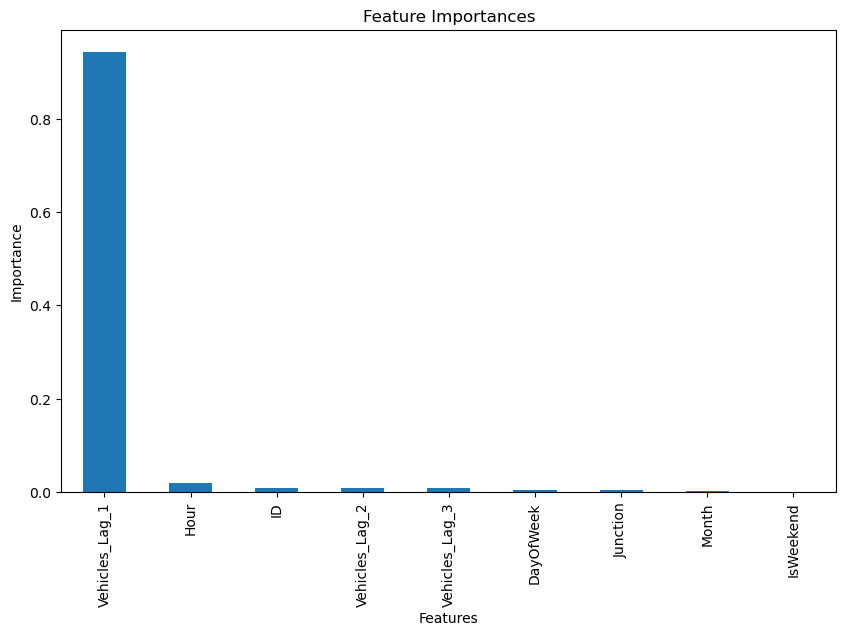

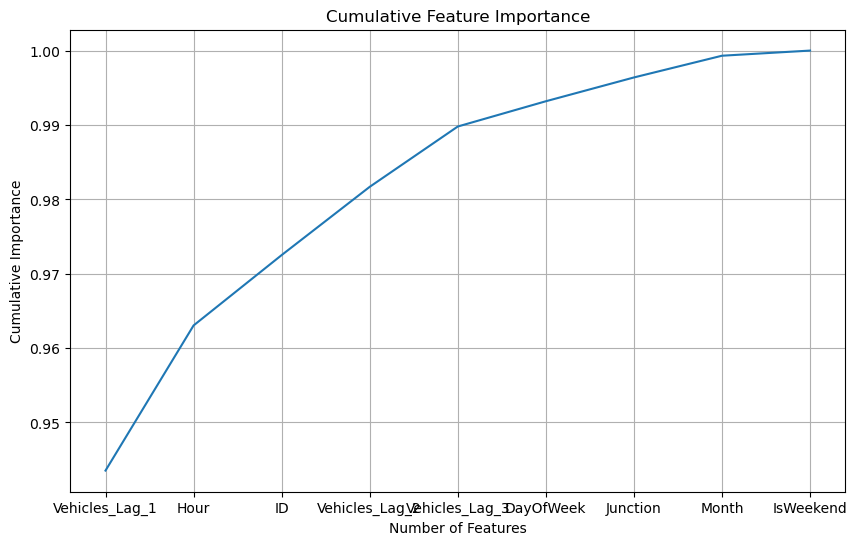

Selected Features: Index(['Vehicles_Lag_1'], dtype='object')


In [19]:
#Sort feature importances

sorted_importances = feature_importances.sort_values(ascending=False)

#Plot feature importances

plt.figure(figsize=(10, 6))
sorted_importances.plot(kind='bar')
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

#Calculate cumulative importance

cumulative_importance = sorted_importances.cumsum()
plt.figure(figsize=(10, 6))
cumulative_importance.plot()
plt.title('Cumulative Feature Importance')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.grid(True)
plt.show()

#Set a threshold for cumulative importance 

threshold = 0.95
selected_features = cumulative_importance[cumulative_importance <= threshold].index

print("Selected Features:", selected_features)

In [20]:
#Select features with cumulative importance less than or equal to the threshold

selected_features = cumulative_importance[cumulative_importance <= threshold].index

#Print selected features

print("\nSelected Features:", selected_features)

#Filter the original data to include only the selected features

X_selected = X[selected_features]

#For further analysis or model training

print("\nData with Selected Features:\n", X_selected.head())


Selected Features: Index(['Vehicles_Lag_1'], dtype='object')

Data with Selected Features:
    Vehicles_Lag_1
0             NaN
1            15.0
2            13.0
3            10.0
4             7.0


In [21]:
#3. Statistical Tests:
#Use statistical tests like ANOVA or chi-square to determine the significance of categorical variables.
# Example with continuous variables (ANOVA)

categorical_columns = ['Hour', 'Month', 'DayOfWeek', 'IsWeekend']

for col in categorical_columns:
    # Perform ANOVA test for 'col' against 'Vehicles'
    f_statistic, p_value = f_oneway(df[col], df['Vehicles'])
    print(f"ANOVA Test for {col}: F-statistic = {f_statistic}, p-value = {p_value}")

ANOVA Test for Hour: F-statistic = 12821.825077910167, p-value = 0.0
ANOVA Test for Month: F-statistic = 31028.04449685858, p-value = 0.0
ANOVA Test for DayOfWeek: F-statistic = 43390.62932313309, p-value = 0.0
ANOVA Test for IsWeekend: F-statistic = 56587.24711160915, p-value = 0.0


In [22]:
#Load the dataset into a Pandas DataFrame

df2 = pd.read_csv('WeatherEvent_data2.csv', encoding='latin-1')

In [23]:
#Display the first few rows of the dataset

print(df2.head())

         Event        Date  Temperature (°F)  Humidity (%)  Pressure (in)  \
0       Diwali  02/11/2023                77            65          29.11   
1         Holi  12/03/2023                82            35          29.11   
2     Navratri  21/09/2023                86            70          28.88   
3   Durga Puja  21/09/2023                86            70          28.88   
4  Eid al-Fitr  10/04/2023                88            17          29.05   

   Wind Speed (mph)  
0                 3  
1                 3  
2                 5  
3                 5  
4                 3  


In [24]:
#Summary statistics

print(df2.describe())

       Temperature (°F)  Humidity (%)  Pressure (in)  Wind Speed (mph)
count         51.000000     51.000000      51.000000         51.000000
mean          74.509804     56.823529      28.990000          4.529412
std           12.914136     18.031867       0.154143          2.166591
min           52.000000     11.000000      28.620000          0.000000
25%           62.000000     45.000000      28.880000          3.000000
50%           77.000000     63.000000      29.020000          5.000000
75%           86.000000     70.000000      29.110000          6.000000
max           95.000000     88.000000      29.250000          9.000000


In [25]:
#Information about the dataset

print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Event             51 non-null     object 
 1   Date              51 non-null     object 
 2   Temperature (°F)  51 non-null     int64  
 3   Humidity (%)      51 non-null     int64  
 4   Pressure (in)     51 non-null     float64
 5   Wind Speed (mph)  51 non-null     int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 2.5+ KB
None


In [26]:
#Format Consistency

df2['DateTime'] = pd.to_datetime(df2['Date'], format='%d/%m/%Y') + pd.to_timedelta('12:00:00')

# Now 'DateTime' column will have the date with a time of 12:00:00 (noon)
print(df2['DateTime'].head())

0   2023-11-02 12:00:00
1   2023-03-12 12:00:00
2   2023-09-21 12:00:00
3   2023-09-21 12:00:00
4   2023-04-10 12:00:00
Name: DateTime, dtype: datetime64[ns]


In [27]:
#Step 1: Merge traffic, weather, and event data
#Convert DateTime columns to datetime if not already

df['DateTime'] = pd.to_datetime(df['DateTime'])
df2['DateTime'] = pd.to_datetime(df2['DateTime'])

#Sort both DataFrames by DateTime

df_sorted = df.sort_values('DateTime')
df2_sorted = df2.sort_values('DateTime')

#Merge based on closest datetime match using merge_asof

merged_data = pd.merge_asof(df_sorted, df2_sorted, on='DateTime', direction='nearest')

#Print first few rows to verify

print(merged_data.head())

#Assuming you have already merged your data into a DataFrame called merged_data

merged_data.to_csv('merged_traffic_weather_events.csv', index=False)

             DateTime Junction  Vehicles           ID  Hour  DayOfWeek  Month  \
0 2015-11-01 00:00:00        1        15  20151101001     0          6     11   
1 2015-11-01 00:00:00        2         6  20151101002     0          6     11   
2 2015-11-01 00:00:00        3         9  20151101003     0          6     11   
3 2015-11-01 01:00:00        3         7  20151101013     1          6     11   
4 2015-11-01 01:00:00        1        13  20151101011     1          6     11   

   Vehicles_Lag_1  Vehicles_Lag_2  Vehicles_Lag_3  IsWeekend           Event  \
0             NaN             NaN             NaN          1  New Year's Day   
1            78.0            84.0            90.0          1  New Year's Day   
2            27.0            29.0            31.0          1  New Year's Day   
3             9.0            27.0            29.0          1  New Year's Day   
4            15.0             NaN             NaN          1  New Year's Day   

         Date  Temperature (°F) 

In [6]:
#Load the dataset

df3 = pd.read_csv('merged_traffic_weather_events.csv')

#Convert DateTime to datetime type with the correct format

df3['DateTime'] = pd.to_datetime(df3['DateTime'], format='%Y-%m-%d %H:%M:%S')

#Display the first few rows of the DataFrame

print(df3.head())

#Check for any missing values

print("Missing values in each column:\n", df3.isnull().sum())

             DateTime  Junction  Vehicles           ID  Hour  DayOfWeek  \
0 2015-11-01 00:00:00         1        15  20151101001     0          6   
1 2015-11-01 00:00:00         2         6  20151101002     0          6   
2 2015-11-01 00:00:00         3         9  20151101003     0          6   
3 2015-11-01 01:00:00         3         7  20151101013     1          6   
4 2015-11-01 01:00:00         1        13  20151101011     1          6   

   Month  Vehicles_Lag_1  Vehicles_Lag_2  Vehicles_Lag_3  IsWeekend  \
0     11             NaN             NaN             NaN          1   
1     11            78.0            84.0            90.0          1   
2     11            27.0            29.0            31.0          1   
3     11             9.0            27.0            29.0          1   
4     11            15.0             NaN             NaN          1   

            Event        Date  Temperature (°F)  Humidity (%)  Pressure (in)  \
0  New Year's Day  01/01/2023             

In [29]:
#Handle data quality issues
#Handle missing values
#Fill missing values for numerical columns with mean

numerical_cols = df3.select_dtypes(include=['float64', 'int64']).columns
df3[numerical_cols] = df3[numerical_cols].fillna(df3[numerical_cols].mean())

#Fill missing values for categorical columns with the most frequent value

categorical_cols = df3.select_dtypes(include=['object']).columns
df3[categorical_cols] = df3[categorical_cols].apply(lambda x: x.fillna(x.mode()[0]))

#Normalize or standardize data
#Standardizing numerical columns to bring different variables to a common scale

scaler = StandardScaler()
df3[numerical_cols] = scaler.fit_transform(df3[numerical_cols])

In [30]:
#Display the cleaned DataFrame

print(df3.head())

#Check for any remaining missing values

print("Remaining missing values in each column:\n", df3.isnull().sum())

             DateTime  Junction  Vehicles        ID      Hour  DayOfWeek  \
0 2015-11-01 00:00:00 -1.220905 -0.375489 -2.052469 -1.661325   1.501998   
1 2015-11-01 00:00:00 -0.186721 -0.809227 -2.052469 -1.661325   1.501998   
2 2015-11-01 00:00:00  0.847464 -0.664648 -2.052468 -1.661325   1.501998   
3 2015-11-01 01:00:00  0.847464 -0.761034 -2.052467 -1.516862   1.501998   
4 2015-11-01 01:00:00 -1.220905 -0.471875 -2.052467 -1.516862   1.501998   

      Month  Vehicles_Lag_1  Vehicles_Lag_2  Vehicles_Lag_3  IsWeekend  \
0  1.433039   -1.712169e-16        0.000000        0.000000   1.586677   
1  1.433039    2.660675e+00        2.949834        3.238990   1.586677   
2  1.433039    2.028185e-01        0.299204        0.395584   1.586677   
3  1.433039   -6.646602e-01        0.202818        0.299198   1.586677   
4  1.433039   -3.755006e-01        0.000000        0.000000   1.586677   

            Event        Date  Temperature (°F)  Humidity (%)  Pressure (in)  \
0  New Year's Day 

In [31]:
#Generate some sample data

data = np.sin(np.arange(0, 100, 0.1))  
data = data.reshape(-1, 1)

#Scaling the data

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

#Function to create dataset for LSTM

def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 10
X, Y = create_dataset(scaled_data, time_step)

#Splitting data into training and testing sets

train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

#Reshaping input to be [samples, time steps, features] for LSTM

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

#LSTM model

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, Y_train, batch_size=1, epochs=1)

#Prediction and evaluation

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

#Inverse transform to get actual values

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))

#Inverse transform Y_test to get actual values

Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))

#Calculate MAE and RMSE

mae = mean_absolute_error(Y_test, test_predict)
rmse = np.sqrt(mean_squared_error(Y_test, test_predict))

print(f"LSTM Model - MAE: {mae}, RMSE: {rmse}")




7/7 [==============================] - 0s 6ms/step
LSTM Model - MAE: 0.018298526258618813, RMSE: 0.02106280065503897


In [32]:
#Step 1: Prepare the Data
#Target column

target_column = 'Vehicles'

#Scale the data

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df3[[target_column]].values)

#Function to create dataset

def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 10
X, Y = create_dataset(scaled_data, time_step)

#Time-based split

split_ratio = 0.8
train_size = int(len(X) * split_ratio)
X_train, X_val = X[:train_size], X[train_size:]
Y_train, Y_val = Y[:train_size], Y[train_size:]

#Reshaping input to be [samples, time steps, features]

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)


In [33]:
#Step 2: Hyperparameter Tuning with KerasTuner
#Define a model building function for KerasTuner

def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32), return_sequences=True, input_shape=(time_step, 1)))
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32), return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

#Initialize KerasTuner RandomSearch

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='my_dir',
    project_name='traffic_volume_prediction'
)

#Perform hyperparameter tuning

tuner.search(X_train, Y_train, epochs=10, validation_data=(X_val, Y_val))

#Get the best model

best_model = tuner.get_best_models(num_models=1)[0]

#Evaluate the best model on the validation set

val_predict = best_model.predict(X_val)
val_predict = scaler.inverse_transform(val_predict)
Y_val = scaler.inverse_transform(Y_val.reshape(-1, 1))

mae = mean_absolute_error(Y_val, val_predict)
rmse = np.sqrt(mean_squared_error(Y_val, val_predict))

print(f"Best LSTM Model - MAE: {mae}, RMSE: {rmse}")


Reloading Tuner from my_dir\traffic_volume_prediction\tuner0.json
301/301 [==============================] - 14s 41ms/step
Best LSTM Model - MAE: 0.8776378463671811, RMSE: 1.130703282888675


Validation Metrics:
MAE: 0.8776378463671811
RMSE: 1.130703282888675
R-squared: 0.25739596095605355


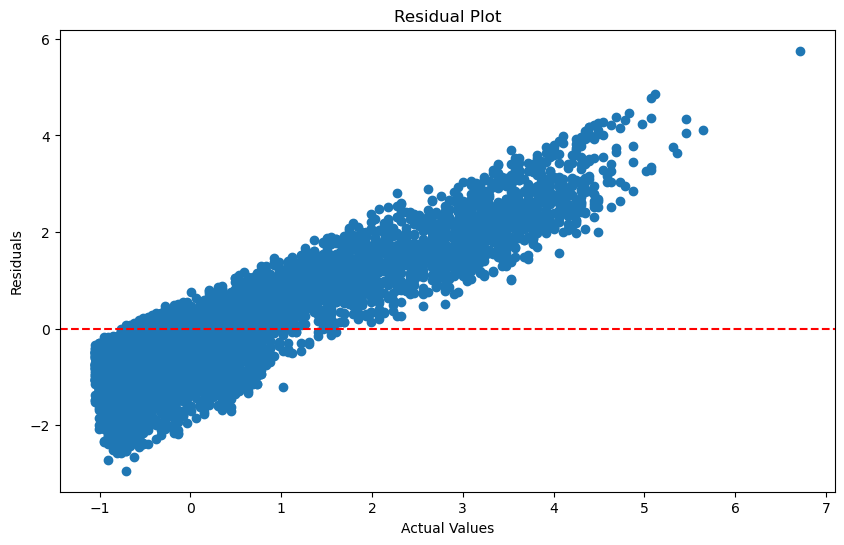

In [35]:
#Calculate metrics

mae = mean_absolute_error(Y_val, val_predict)
rmse = np.sqrt(mean_squared_error(Y_val, val_predict))
r2 = r2_score(Y_val, val_predict)

print(f"Validation Metrics:\nMAE: {mae}\nRMSE: {rmse}\nR-squared: {r2}")

#Residual plot

residuals = Y_val - val_predict
plt.figure(figsize=(10, 6))
plt.scatter(Y_val, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

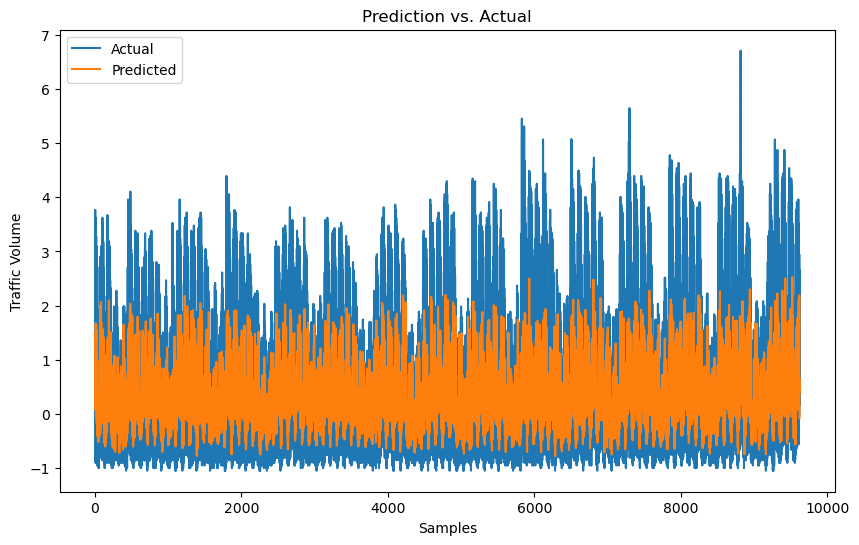

In [37]:
#Prediction vs. Actual plot

plt.figure(figsize=(10, 6))
plt.plot(Y_val, label='Actual')
plt.plot(val_predict, label='Predicted')
plt.xlabel('Samples')
plt.ylabel('Traffic Volume')
plt.title('Prediction vs. Actual')
plt.legend()
plt.show()

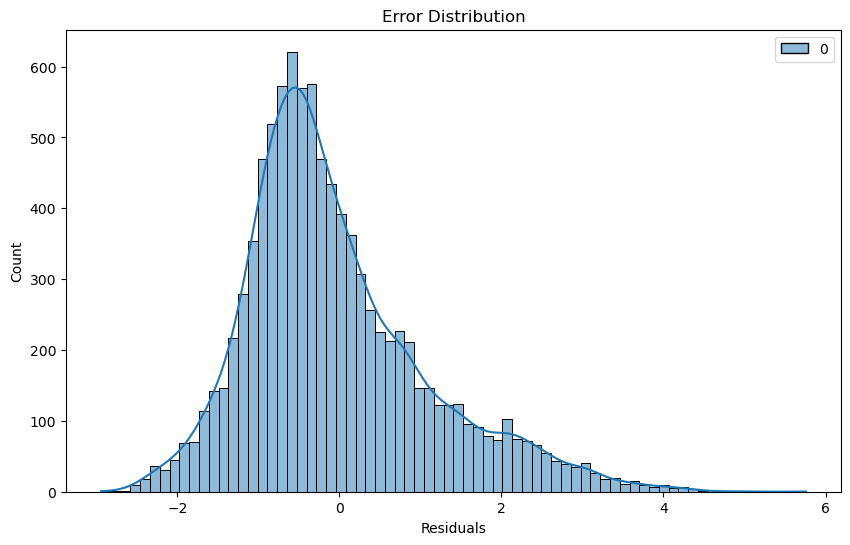

In [38]:
#Error distribution plot

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Error Distribution')
plt.show()

In [41]:
#TimeSeriesSplit for time-based cross-validation

tscv = TimeSeriesSplit(n_splits=5)

mae_scores = []
rmse_scores = []
r2_scores = []

for train_index, val_index in tscv.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    Y_train_fold, Y_val_fold = Y_train[train_index], Y_train[val_index]
    
    #Reshape input data to fit LSTM model
    
    X_train_fold = X_train_fold.reshape((X_train_fold.shape[0], X_train_fold.shape[1], 1))
    X_val_fold = X_val_fold.reshape((X_val_fold.shape[0], X_val_fold.shape[1], 1))
    
    #Build and train the model
    
    model = Sequential()
    model.add(LSTM(512, return_sequences=True, input_shape=(X_train_fold.shape[1], 1)))
    model.add(LSTM(512, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    
    model.fit(X_train_fold, Y_train_fold, epochs=10, batch_size=32, verbose=1)
    
    #Predict on validation set
    
    Y_val_pred = model.predict(X_val_fold)
    
    #Calculate metrics
    
    mae = mean_absolute_error(Y_val_fold, Y_val_pred)
    rmse = np.sqrt(mean_squared_error(Y_val_fold, Y_val_pred))
    r2 = r2_score(Y_val_fold, Y_val_pred)
    
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

#Average metrics over all folds

avg_mae = np.mean(mae_scores)
avg_rmse = np.mean(rmse_scores)
avg_r2 = np.mean(r2_scores)

print(f"Cross-Validation Results - MAE: {avg_mae}, RMSE: {avg_rmse}, R-squared: {avg_r2}")


Epoch 1/10
201/201 [==============================] - 65s 222ms/step - loss: 0.0024
Epoch 2/10
201/201 [==============================] - 35s 175ms/step - loss: 0.0021
Epoch 3/10
201/201 [==============================] - 37s 185ms/step - loss: 0.0022
Epoch 4/10
201/201 [==============================] - 35s 175ms/step - loss: 0.0022
Epoch 5/10
201/201 [==============================] - 35s 175ms/step - loss: 0.0022
Epoch 6/10
201/201 [==============================] - 35s 177ms/step - loss: 0.0021
Epoch 7/10
201/201 [==============================] - 36s 177ms/step - loss: 0.0021
Epoch 8/10
201/201 [==============================] - 35s 175ms/step - loss: 0.0021
Epoch 9/10
201/201 [==============================] - 35s 175ms/step - loss: 0.0021
Epoch 10/10
201/201 [==============================] - 33s 39ms/step
Epoch 1/10
401/401 [==============================] - 75s 177ms/step - loss: 0.0030
Epoch 2/10
401/401 [==============================] - 71s 177ms/step - loss: 0.0029
Epoch 3

In [42]:
#Analysis of Cross-Validation Results:
#Consistency: Cross-validation helps evaluate the consistency of your model's performance across different 
#subsets of data. The consistent values of MAE and RMSE across folds suggest that your model is performing 
#similarly on different parts of the dataset.

#Patterns or Issues: The low R-squared value (0.152) indicates that your model may not capture a significant 
#portion of the variance in the data, suggesting potential underfitting. This could mean that the model might 
#not be complex enough to capture the underlying patterns in the data adequately.

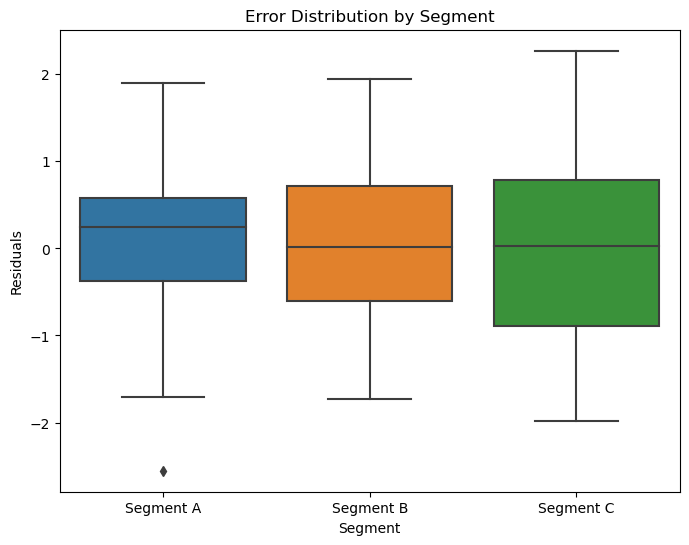

In [49]:
#Example data generation

np.random.seed(0)
segments = ['Segment A', 'Segment B', 'Segment C']
residuals = np.random.randn(100)  # Replace with actual residuals data

#Create a DataFrame

error_data = pd.DataFrame({'segment': np.random.choice(segments, 100), 'residuals': residuals})

#Example boxplot using seaborn

plt.figure(figsize=(8, 6))
sns.boxplot(x='segment', y='residuals', data=error_data)
plt.xlabel('Segment')
plt.ylabel('Residuals')
plt.title('Error Distribution by Segment')
plt.show()

In [9]:
#RandomizedSearchCV, which is a method for hyperparameter tuning that randomly selects combinations of 
#hyperparameters from given distributions (param_dist). It then evaluates these combinations using cross-validation 
#to find the best parameters based on a scoring metric (neg_mean_squared_error in this case).

df3_numeric = df3.select_dtypes(include=[np.number])

#Define the parameter distributions for RandomizedSearchCV

param_dist = {
    'n_estimators': randint(50, 200),  
    'max_depth': [None, 10, 20],
    'min_samples_split': randint(2, 10),  
    'min_samples_leaf': randint(1, 5),   
    'max_features': ['auto', 'sqrt']
}

#Instantiate the RandomForestRegressor

rf = RandomForestRegressor(random_state=42)

#Handle missing values by imputing with the mean

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(df3_numeric.drop(columns=['Vehicles']))
y = df3_numeric['Vehicles']

#Instantiate RandomizedSearchCV

random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=100, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

#Fit RandomizedSearchCV

random_search.fit(X_imputed, y)

#Print best parameters and best score

print("Best parameters found: ", random_search.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(random_search.best_score_)))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Best parameters found:  {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 195}
Lowest RMSE found:  4.173854596467783


In [ ]:
#This configuration achieved a root mean squared error (RMSE) of approximately 4.17, suggesting a reasonably 
#good fit to the data. These parameters collectively led to the model producing predictions that closely matched 
#the actual values, indicating effective tuning through hyperparameter optimization.